In [1]:
%%capture
import os

# check if this is a colab notebook and clone the repo if it is
if 'COLAB_GPU' in os.environ:
    %cd /content/
    !git clone https://github.com/Enver-group/twitch-web-analytics
    %cd twitch-web-analytics/
    !gdown --id 11IfXaA66-D7vjA2R46uAilBgOPxYmKmn
    !pip install -r requirements.txt
    !pip install -e .
    %cd notebooks/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_feather("../data/streamers.feather").set_index("id")
df.head(5)

,name,num_followers,broadcaster_type,description,lang,last_game_played_name,view_count,profile_image_url,created_at,user_follows
id,,,,,,,,,,
459331509,auronplay,10874205.0,partner,feliz pero no mucho,es,Minecraft,212166590,https://static-cdn.jtvnw.net/jtv_user_pictures...,2019-09-03 14:02:49,"[210708721, 431460701, 77649106, 130065491, 42..."
39276140,Rubius,10483570.0,partner,se contar hasta patata,es,Propnight,222921576,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-01-12 18:46:56,"[91136321, 198363811, 210708721, 133528221, 70..."
48878319,TheGrefg,8708686.0,partner,"Hola, me llamo David, me quedé calvo delante d...",es,Five Nights at Freddy's,197916916,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-09-12 00:45:27,"[143776262, 675347177, 33734881, 248222879, 18..."
83232866,ibai,8536480.0,partner,Si lees esto que sepas que te aprecio,es,VALORANT,286994651,https://static-cdn.jtvnw.net/jtv_user_pictures...,2015-02-20 16:47:56,"[35980866, 145908612, 205218019, 91136321, 524..."
121510236,juansguarnizo,6013625.0,partner,"Juan Sebastián Guarnizo Algarra, más conocido ...",es,Just Chatting,127964660,https://static-cdn.jtvnw.net/jtv_user_pictures...,2016-04-11 03:34:11,"[43419527, 517536651, 476005292, 109492660, 55..."


In [3]:
G = nx.from_pandas_edgelist(
    df.reset_index().explode("user_follows"),
    source="id",
    target="user_follows",
    create_using=nx.DiGraph()
)
nx.set_node_attributes(G, name='name', values=df.name.to_dict())
nx.set_node_attributes(G, name='num_followers', values=df.num_followers.to_dict())
nx.set_node_attributes(G, name='view_count', values=df.view_count.to_dict())


In [4]:
# checking the nodes of the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges(), "\n")
for i, user in enumerate(list(G.out_degree())):
  if i > 5:
    break
  elif i==5:
    user = "61127118",G.out_degree("61127118")
  print(G.nodes[user[0]]["name"], "follows", user[1], "users")

print()
for i, user in enumerate(list(G.in_degree())+["61127118"]):
  if i > 5:
    break
  elif i==5:
    user = "61127118",G.in_degree("61127118")
  print(G.nodes[user[0]]["name"], "is followed by", user[1], "users in the dataset")

Number of nodes: 75631
Number of edges: 1436042 

auronplay follows 45 users
josecristo_ follows 103 users
xXxTheFocuSxXx follows 90 users
Ampeterby7 follows 114 users
javiDMr10 follows 106 users
DavimenXPro follows 16 users

auronplay is followed by 4044 users in the dataset
josecristo_ is followed by 149 users in the dataset
xXxTheFocuSxXx is followed by 295 users in the dataset
Ampeterby7 is followed by 682 users in the dataset
javiDMr10 is followed by 103 users in the dataset
DavimenXPro is followed by 2 users in the dataset


In [3]:
from src.utils import remove_outside_follows, df_to_nx
small_df = remove_outside_follows(
    df[(~df.user_follows.isnull())&(~df.num_followers.isnull())]
).sort_values("num_followers",ascending=False)
small_G = df_to_nx(small_df.head(50) )


ImportError: cannot import name 'remove_outside_follows' from 'src.utils' (/home/simon/Documents/Uni/WebAnalytics/TwitchProject/src/utils.py)

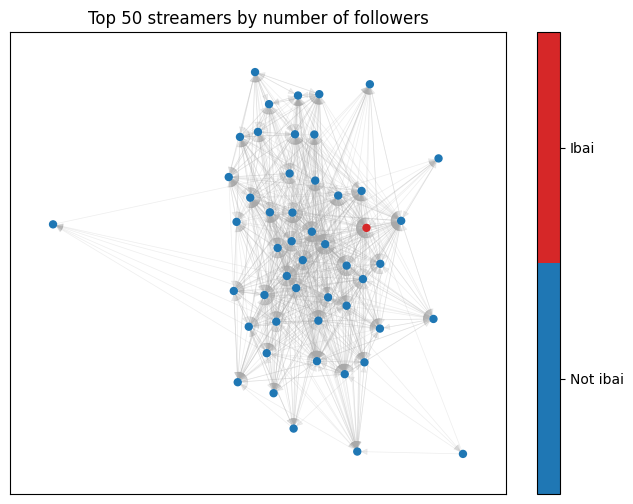

In [90]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# default matplotlib style
plt.style.use('default')

# set background color of figure to be white
plt.rcParams['figure.facecolor'] = 'white'

groups = [small_G.nodes[n]["name"].lower()=="ibai" for n in small_G.nodes] 
group_map = {"Ibai":1, "Not ibai":0}

cmap = mpl.colors.ListedColormap(["tab:blue", "tab:red", ])#"tab:green", "tab:orange"])
norm = mpl.colors.BoundaryNorm(np.arange(0,cmap.N), cmap.N)

fig, ax = plt.subplots(1,1,figsize=(8,6))

# pos = nx.spring_layout(small_G)
pos = nx.spring_layout(small_G)
nx.draw_networkx_edges(small_G, pos,node_size=25,alpha=0.2,width=0.5,edge_color='darkgrey', ax=ax)
nx.draw_networkx_nodes(small_G, pos, node_size=25, node_color=groups, cmap=cmap, ax=ax)
ax.set_title("Top 50 streamers by number of followers");

cbar = fig.colorbar(ax.collections[0], ticks=np.arange(0.5,cmap.N)/cmap.N,orientation='vertical')
cbar.set_ticklabels(sorted(group_map,key=lambda k: group_map[k]))
plt.show()